In [ ]:
!pip install d2l==1.0.0-alpha1.post0


# Linear Regression

In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

n = 10000
a = torch.ones(n)
b = torch.ones(n)

c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{time.time() - t:.5f} sec')

0.15924 sec


In [ ]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00101 sec'

In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# Object-Oriented Design for Implementation

In [ ]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

class ProgressBoard(d2l.HyperParameters):
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [ ]:
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [ ]:
class DataModule(d2l.HyperParameters):
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [ ]:
class Trainer(d2l.HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

# Synthetic Regression Data

In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

class SyntheticRegressionData(d2l.DataModule):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

print('features:', data.X[0],'\nlabel:', data.y[0])

In [ ]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

In [ ]:
@d2l.add_to_class(d2l.DataModule) 
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

len(data.train_dataloader()) #32

# Linear Regression Implementation from Scratch

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

class LinearRegressionScratch(d2l.Module): 
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)  
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

In [ ]:
@d2l.add_to_class(LinearRegressionScratch) 
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

In [ ]:
class SGD(d2l.HyperParameters): 
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

@d2l.add_to_class(LinearRegressionScratch) 
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [ ]:
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [ ]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

# Concise Implementation of Linear Regression

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class LinearRegression(d2l.Module):  
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [ ]:
@d2l.add_to_class(LinearRegression)  
def forward(self, X):
    return self.net(X)

In [ ]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

In [ ]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

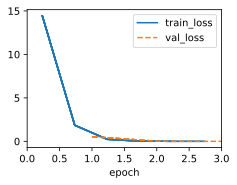

In [ ]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [ ]:
@d2l.add_to_class(LinearRegression)
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

In [ ]:
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

# 새 섹션

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.00984874926507473


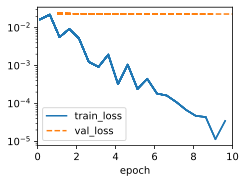

In [ ]:
train_scratch(0)

L2 norm of w: 0.0013237446546554565


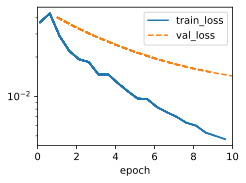

In [ ]:
train_scratch(3)

In [ ]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.013002106919884682


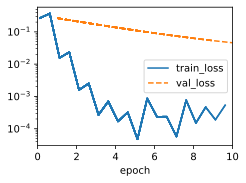

In [ ]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))